In [1]:
 import pandas as pd

# transformer
from sklearn.base import BaseEstimator, TransformerMixin

# pipeline
from nltk.tokenize import word_tokenize
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

In [2]:
toefl = pd.read_csv('toefl11_trainingdata_features')
toefl = toefl.drop(['Unnamed: 0','Unnamed: 0.1'], axis= 1)

In [3]:
test = pd.read_csv('Featured_Data/test_features.csv')

In [4]:
class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        
    def fit(self, x, y=None):
        return self
    
    def transform(self, data_dict):
        return data_dict[self.key]

## NLI

In [44]:
#Pipeline
#define features and y 
y = toefl.drop(['Filename','text','POS','DEP', 'NER', 'prop_punct', 'prop_capwords', 'prop_capI','avg_sentlength'], axis = 1)
x = toefl.drop(['Filename', 'Language', 'Proficiency', 'NER', 'prop_capwords',], axis = 1)
X_train, X_dev, y_train, y_dev = train_test_split(x, y['Language'], test_size= 0.10, random_state = 11)

In [45]:
numeric_features = ['prop_punct', 'avg_sentlength', 'prop_capI']
tfidfvect = TfidfVectorizer()
linsvm = LinearSVC()
#refit with best ranges
numfeat_pipe = Pipeline([
    ('selector', ItemSelector(key=numeric_features))
])

# pipe word n-grams
text_pipe = Pipeline([
    ('selector', ItemSelector(key='text')),
    ('vect', TfidfVectorizer(
        tokenizer=word_tokenize,
        analyzer='word',
        lowercase=True,
        ngram_range=(1,2)))
])

# pipe char n-grams
char_pipe = Pipeline([
    ('selector', ItemSelector(key="text")),
    ('vect', TfidfVectorizer(
        analyzer='char',
        lowercase=True,
        ngram_range=(2,4)))
])

# pipe POS n-grams
pos_pipe = Pipeline([
    ('selector', ItemSelector(key="POS")),
    ('vect', TfidfVectorizer(
        analyzer='word',
        lowercase=True,
        ngram_range=(1,3)))
])

# pipe complete
pipe = Pipeline([
    ('feats', FeatureUnion([
        ('numfeat_pipe', numfeat_pipe),
        ('text_pipe', text_pipe),
        ('char_pipe', char_pipe),
        ('pos_pipe', pos_pipe)
    ])),
    ('cls', linsvm)
])

In [47]:
# fit model
pipe.fit(X_train, y_train)

C:\Users\robin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Pipeline(steps=[('feats',
                 FeatureUnion(transformer_list=[('numfeat_pipe',
                                                 Pipeline(steps=[('selector',
                                                                  ItemSelector(key=['prop_punct',
                                                                                    'avg_sentlength',
                                                                                    'prop_capI']))])),
                                                ('text_pipe',
                                                 Pipeline(steps=[('selector',
                                                                  ItemSelector(key='text')),
                                                                 ('vect',
                                                                  TfidfVectorizer(ngram_range=(1,
                                                                                               2),
                        

In [8]:
# prediction
y_dev_pred = pipe.predict(X_dev)

# accuracy
print(classification_report(y_dev, y_dev_pred))

              precision    recall  f1-score   support

         ARA       0.81      0.75      0.78        93
         DEU       0.90      0.91      0.91       102
         FRA       0.81      0.79      0.80        99
         HIN       0.68      0.76      0.72       102
         ITA       0.87      0.85      0.86        89
         JPN       0.76      0.76      0.76        98
         KOR       0.78      0.81      0.79       103
         SPA       0.78      0.80      0.79        86
         TEL       0.76      0.73      0.75       104
         TUR       0.89      0.81      0.85       118
         ZHO       0.82      0.88      0.85       106

    accuracy                           0.81      1100
   macro avg       0.81      0.81      0.81      1100
weighted avg       0.81      0.81      0.81      1100



In [22]:
cv_results = cross_val_predict(pipe, x, y['Language'], cv=10, verbose=True, n_jobs=-1)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 42.1min finished


In [29]:
print(classification_report(y['Language'], cv_results))

              precision    recall  f1-score   support

         ARA       0.84      0.75      0.79      1000
         DEU       0.86      0.93      0.89      1000
         FRA       0.83      0.82      0.83      1000
         HIN       0.70      0.74      0.72      1000
         ITA       0.87      0.86      0.87      1000
         JPN       0.82      0.79      0.81      1000
         KOR       0.78      0.78      0.78      1000
         SPA       0.76      0.77      0.77      1000
         TEL       0.78      0.77      0.77      1000
         TUR       0.86      0.86      0.86      1000
         ZHO       0.84      0.87      0.86      1000

    accuracy                           0.81     11000
   macro avg       0.81      0.81      0.81     11000
weighted avg       0.81      0.81      0.81     11000



In [41]:
from sklearn.model_selection import cross_val_score
print(cross_val_score(pipe, x, y['Language'], cv = 10))

[0.77363636 0.82545455 0.81272727 0.81272727 0.81727273 0.83272727
 0.80090909 0.81818182 0.82545455 0.81090909]


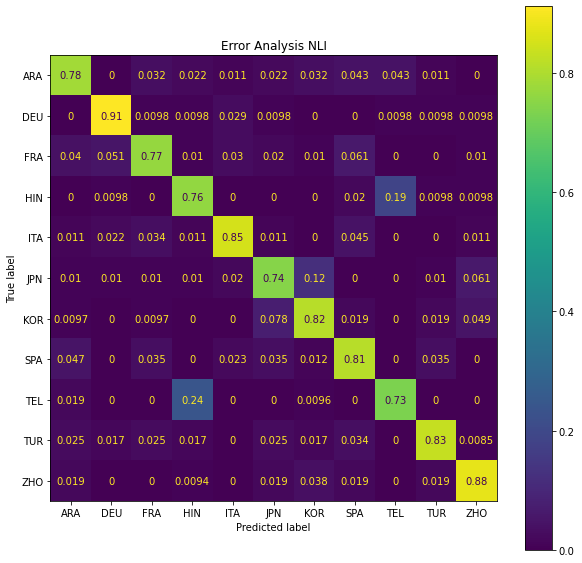

In [67]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix, ConfusionMatrixDisplay
plt.rcParams["figure.figsize"] = (10,10)
cm = plot_confusion_matrix(pipe, X_dev, y_dev , normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = pipe.classes_)
plt.title('Error Analysis NLI')
plt.plot()
plt.savefig('cm_lang.png')
plt.show()

In [17]:
test_predict_Language = pipe.predict(test)

test['Predicted_Language'] = test_predict_Language
test

## Proficiency

In [68]:
y = toefl.drop(['Filename','text','POS','DEP', 'NER', 'prop_punct', 'prop_capwords', 'prop_capI','avg_sentlength'], axis = 1)
x = toefl.drop(['Filename', 'Language', 'Proficiency', 'NER', 'prop_capwords','avg_sentlength'], axis = 1)
X_train, X_dev, y_train, y_dev = train_test_split(x, y['Proficiency'], test_size= 0.10, random_state = 11)
# dropping avg_sent lenght as well

In [69]:
numeric_features = ['prop_punct', 'prop_capI']
tfidfvect = TfidfVectorizer()

linsvm = LinearSVC()
#refit with best ranges
numfeat_pipe = Pipeline([
    ('selector', ItemSelector(key=numeric_features))
])

# pipe word n-grams
text_pipe = Pipeline([
    ('selector', ItemSelector(key='text')),
    ('vect', TfidfVectorizer(
        tokenizer=word_tokenize,
        analyzer='word',
        lowercase=True,
        ngram_range=(1,2)))
])

# pipe char n-grams
char_pipe = Pipeline([
    ('selector', ItemSelector(key="text")),
    ('vect', TfidfVectorizer(
        analyzer='char',
        lowercase=True,
        ngram_range=(2,3)))
])

# pipe POS n-grams
pos_pipe = Pipeline([
    ('selector', ItemSelector(key="POS")),
    ('vect', TfidfVectorizer(
        analyzer='word',
        lowercase=True,
        ngram_range=(1,4)))
])

# pipe complete
pipe = Pipeline([
    ('feats', FeatureUnion([
        ('numfeat_pipe', numfeat_pipe),
        ('text_pipe', text_pipe),
        ('char_pipe', char_pipe),
        ('pos_pipe', pos_pipe)
    ])),
    ('cls', linsvm)
])

In [70]:
# fit model
pipe.fit(X_train, y_train)

Pipeline(steps=[('feats',
                 FeatureUnion(transformer_list=[('numfeat_pipe',
                                                 Pipeline(steps=[('selector',
                                                                  ItemSelector(key=['prop_punct',
                                                                                    'prop_capI']))])),
                                                ('text_pipe',
                                                 Pipeline(steps=[('selector',
                                                                  ItemSelector(key='text')),
                                                                 ('vect',
                                                                  TfidfVectorizer(ngram_range=(1,
                                                                                               2),
                                                                                  tokenizer=<function word_tokenize at 0x00000

In [35]:
from sklearn.metrics import classification_report
# prediction
y_dev_pred = pipe.predict(X_dev)

# accuracy
print(classification_report(y_dev, y_dev_pred))

              precision    recall  f1-score   support

        high       0.66      0.78      0.72       379
         low       0.86      0.40      0.55       120
      medium       0.74      0.74      0.74       601

    accuracy                           0.71      1100
   macro avg       0.75      0.64      0.67      1100
weighted avg       0.73      0.71      0.71      1100



In [43]:
cv_results = cross_val_predict(pipe, x, y['Proficiency'], cv=10, verbose=True, n_jobs=-1)
print(classification_report(y['Proficiency'], cv_results))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.9min finished


              precision    recall  f1-score   support

        high       0.66      0.79      0.72      3835
         low       0.81      0.34      0.48      1201
      medium       0.73      0.72      0.73      5964

    accuracy                           0.71     11000
   macro avg       0.73      0.62      0.64     11000
weighted avg       0.71      0.71      0.70     11000



In [42]:
print(cross_val_score(pipe, x, y['Proficiency'], cv = 10))

[0.71181818 0.69727273 0.70727273 0.72272727 0.70090909 0.68272727
 0.7        0.71090909 0.71818182 0.70090909]


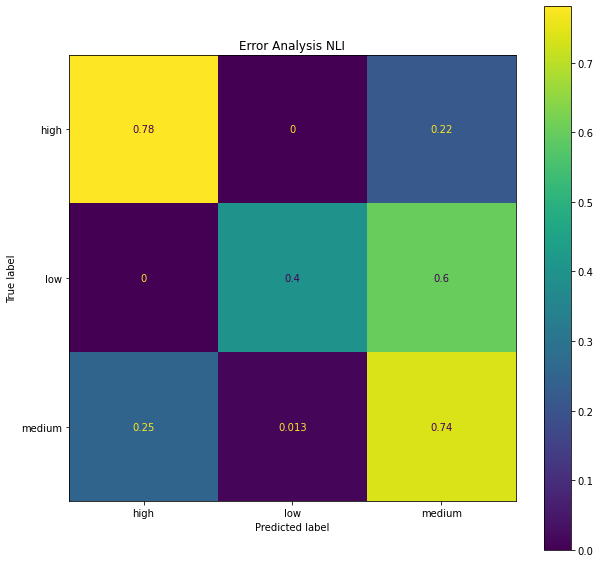

In [71]:
plt.rcParams["figure.figsize"] = (10,10)
cm = plot_confusion_matrix(pipe, X_dev, y_dev , normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = pipe.classes_)
plt.title('Error Analysis NLI')
plt.plot()
plt.savefig('cm_prof.png')
plt.show()

## Predict test labels

In [37]:
test_predict_proficiency = pipe.predict(test)
#test_predict_proficiency

In [25]:
test['Predicted_Proficiency'] = test_predict_proficiency

In [ ]:
output = test[['Filename','text', 'Predicted_Language','Predicted_Proficiency']]
#output

,Filename,text,Predicted_Language,Predicted_Proficiency
0,10226.txt,I agree. Because if I had many academic subjec...,JPN,low
1,10229.txt,"I DO NOT AGREE WITH THIS STATEMENT BECOUSE , N...",ARA,low
2,10392.txt,I am not quite sure about my oppinion on that ...,DEU,high
3,10445.txt,It is often said that young people's interest ...,JPN,high
4,10535.txt,"In mordern society, students always face the d...",ZHO,high
...,...,...,...,...
1095,1175383.txt,There are heated disscussion about that youn...,ZHO,medium
1096,1175412.txt,In my personal opinion young people do not spe...,HIN,medium
1097,1175488.txt,I believe that people who take risks are succe...,TUR,high
1098,1175980.txt,With the rapid progress of time everything aro...,TUR,medium


In [ ]:
output.to_csv('predictions_output.csv')